In [515]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

In [516]:
import sys
import os
project_path = os.getcwd() + '/../../'
sys.path.append(project_path + "utils")
sys.path.append(project_path + "data")
sys.path.append(project_path + "multi_models/cnn/")
sys.path.append(project_path + "multi_models/timeseries_model/")
sys.path.append(project_path + "multi_models/knn/")

In [517]:
# utils
import analysis
import function
import other
import local_bayes
import visualize

In [4]:
# data
from base import BaseDataManager
import get_normal_representation 
from preprocessing import Preprocessing
from data import Data

In [5]:
import numpy
from keras.layers import LSTM, GRU, SimpleRNN
sys.path.append(project_path + "multi_models/knn/")

In [6]:
%load_ext autoreload
%autoreload 2
from timeseries_model import TimeseriesModel

In [19]:
sys.path.append(project_path )

In [20]:
from base_estimator import BaseEstimator

In [21]:
base_estimator = BaseEstimator()

## make data

In [384]:
data_name_ls = ['science', 'ajax', 'java', 'news', 'css', 'javascript', 'opensource', 'webdesign', 'design', 'linux', 'photography']
raw_data_dir = project_path + 'original_data/bookmark/'
save_data_dir = project_path + 'data/datasets/bookmark_new/'
train_test_ratio = 0.8
stride = 5
balance = False
output_dim_ls = [2]

base_data_manager = BaseDataManager(raw_data_dir, save_data_dir)
D = Data(raw_data_dir, save_data_dir)
P = Preprocessing(raw_data_dir, save_data_dir)

In [386]:
for output_dim in output_dim_ls:
    
    for data_name in data_name_ls:
        print data_name
        data = base_data_manager.load_raw_data('%s.twd' % data_name)
        ts_ls, ts_sum_ls = get_normal_representation.get_ts_normal_representation(data)
        ts_dict = base_data_manager.div_train_test(ts_ls, train_test_ratio)
        started_ts_dict = base_data_manager.get_started_ts(ts_dict)
        input_ts_dict, label_dict, target_ts_dict, input_sum_dict = \
                                    base_data_manager.make_supervised_data(started_ts_dict, stride, output_dim)
        if balance:
            input_ts_dict, label_dict, target_ts_dict = P.balancing_sampling(input_ts_dict, label_dict, target_ts_dict, output_dim)
            data_type = 'balance'
        else:
            data_type = 'normal'
        D.make_train_data(input_ts_dict, label_dict, target_ts_dict, output_dim, data_type, data_name)

science
ajax
java
news
css
javascript
opensource
webdesign
design
linux
photography


## data load

In [534]:
data_type = 'balance'
output_dim = 1
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [535]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], 1, rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], 1, rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(3599, 1, 1, 30)
train samples: 3599
test samples: 1021


In [400]:
for i in xrange(output_dim):
    all_, sum_ = 0, 0
    for ele in test_ajax['y'][:, i]:
        if abs(ele - 1) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'chance level for dim %s: %s' % (i, sum_ / all_)

chance level for dim 0: 0.228525769077
chance level for dim 1: 0.217738713544
chance level for dim 2: 0.205353575709
chance level for dim 3: 0.191769876149
chance level for dim 4: 0.190571314423
chance level for dim 5: 0.188573711546


## 統計情報

In [401]:
def pattern_analysis(label, pattern):
    if type(pattern) == 'list':
        pattern = numpy.array(pattern)
    ref = [0 for i in xrange(len(pattern))]
    for label_ele in label:
        for i, pattern_ele in enumerate(pattern):
            res = label_ele == pattern_ele
            if res.all():
                ref[i] += 1.0
    return numpy.array(ref) / int(label.shape[0])

In [402]:
pattern = [[0, 0, 0, 0, 0, 0], [1,0,0,0,0,0], [1, 1, 1, 1, 1,1]]
ref = pattern_analysis(y_train, pattern)
ref

array([ 0.52428632,  0.04921176,  0.01640392])

## model

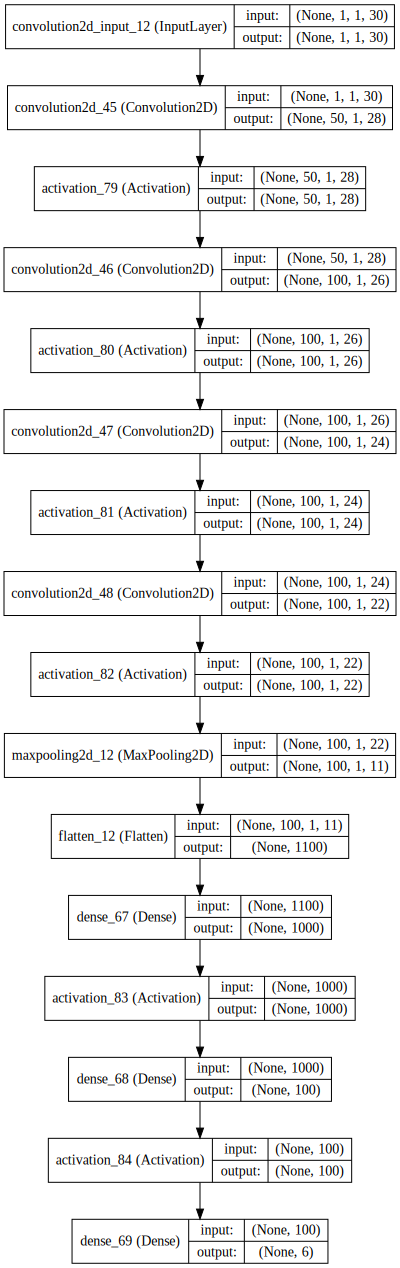

In [232]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Reshape((260, )))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(output_dim = output_dim, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                            optimizer="adam",
                            metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [233]:
epoch = 10
cnn_result = model.fit(x_train, train_ajax['y'], nb_epoch=epoch, batch_size=50, verbose=2,  validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 700 samples, validate on 78 samples
Epoch 1/10
0s - loss: 0.6854 - acc: 0.5929 - val_loss: 0.6713 - val_acc: 0.5513
Epoch 2/10
0s - loss: 0.6350 - acc: 0.7371 - val_loss: 0.6324 - val_acc: 0.7564
Epoch 3/10
0s - loss: 0.6029 - acc: 0.6914 - val_loss: 0.6785 - val_acc: 0.7564
Epoch 4/10
0s - loss: 0.6060 - acc: 0.6857 - val_loss: 0.6869 - val_acc: 0.6667
Epoch 5/10
0s - loss: 0.5963 - acc: 0.6786 - val_loss: 0.6721 - val_acc: 0.6410
Epoch 6/10
0s - loss: 0.5696 - acc: 0.6657 - val_loss: 0.6919 - val_acc: 0.6026
Epoch 7/10
0s - loss: 0.5514 - acc: 0.6329 - val_loss: 0.6772 - val_acc: 0.6410
Epoch 8/10
0s - loss: 0.5383 - acc: 0.6171 - val_loss: 0.7184 - val_acc: 0.6410
Epoch 9/10
0s - loss: 0.5077 - acc: 0.6329 - val_loss: 0.8026 - val_acc: 0.5128
Epoch 10/10
0s - loss: 0.4768 - acc: 0.5814 - val_loss: 0.7868 - val_acc: 0.4359


In [234]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.739130434783
accuracy for 1 th dim: 0.593167701863
accuracy for 2 th dim: 0.608695652174
accuracy for 3 th dim: 0.580745341615
accuracy for 4 th dim: 0.583850931677
accuracy for 5 th dim: 0.571428571429


In [235]:
acc_all, acc_sum, res = 0.0, 0.0, []
for pred, y_test_ in zip(preds, y_test):
    res = pred == y_test_
    acc_sum += 1
    if res.all():
        acc_all += 1.0
acc_all = acc_all / acc_sum
acc_all

0.14285714285714285

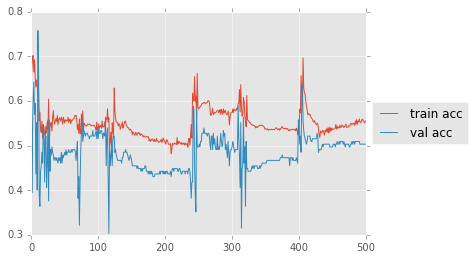

In [194]:
x = range(epoch)
plt.plot(x, cnn_result.history['acc'], label="train acc")
plt.plot(x, cnn_result.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

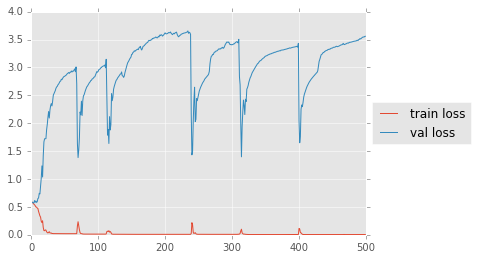

In [195]:
x = range(epoch)
plt.plot(x, cnn_result.history['loss'], label="train loss")
plt.plot(x, cnn_result.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
my_cnn = CNN(rows=1, cols=30, output_dim=6)

In [112]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 0], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

IndexError: invalid index to scalar variable.

## RNN

In [445]:
my_rnn = TimeseriesModel(rows=1, cols=30, output_dim=6, model_type='SimpleRNN')

### data load for RNN

In [446]:
output_dim = 1
train, test, target = base_data_manager.load_normal_representation_data(output_dim=output_dim, data_type='balance', category_name='ajax')
x_train, y_train, x_test, y_test = my_rnn.data_transform(train, test)

In [447]:
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

(3599, 1, 30)
train samples: 3599
test samples: 1021


### model

In [448]:
my_rnn.build(rows=1, cols=30, output_dim=output_dim)

In [449]:
result = my_rnn.train(x_train, y_train, batch_size=50, epoch=50, validation_split=0.1)

Train on 3239 samples, validate on 360 samples
Epoch 1/50
3239/3239 [==============================] - 0s - loss: 0.7655 - acc: 0.5023 - val_loss: 0.7540 - val_acc: 0.5111
Epoch 2/50
3239/3239 [==============================] - 0s - loss: 0.7171 - acc: 0.5526 - val_loss: 0.7301 - val_acc: 0.5556
Epoch 3/50
3239/3239 [==============================] - 0s - loss: 0.6941 - acc: 0.5826 - val_loss: 0.7139 - val_acc: 0.5667
Epoch 4/50
3239/3239 [==============================] - 0s - loss: 0.6789 - acc: 0.5977 - val_loss: 0.6997 - val_acc: 0.5778
Epoch 5/50
3239/3239 [==============================] - 0s - loss: 0.6669 - acc: 0.6144 - val_loss: 0.6869 - val_acc: 0.5889
Epoch 6/50
3239/3239 [==============================] - 0s - loss: 0.6564 - acc: 0.6184 - val_loss: 0.6772 - val_acc: 0.5889
Epoch 7/50
3239/3239 [==============================] - 0s - loss: 0.6473 - acc: 0.6255 - val_loss: 0.6685 - val_acc: 0.5972
Epoch 8/50
3239/3239 [==============================] - 0s - loss: 0.6395 - ac

In [450]:
acc_ls, acc_all = my_rnn.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i + 1, acc_)

accuracy for 1 th dim: 0.717924


In [451]:
acc_all

0.7179236043095005

In [79]:
pattern = []
if type(pattern) == 'list':
    pattern = numpy.array(pattern)
ref = [0 for i in six.moves.range(label.shape[0])]
for label_ele in label:
    for i, pattern_ele in enumerate(pattern):
        res = label_ele == pattern_ele
        if res.all():
            ref[i] += 1

SyntaxError: invalid syntax (<ipython-input-79-f60db428ffe1>, line 1)

## GRU

In [486]:
output_dim = 1
my_gru = TimeseriesModel(rows=1, cols=30, output_dim=output_dim, model_type='GRU')

### data load for GRU

In [487]:
train, test, target = base_data_manager.load_normal_representation_data(output_dim=output_dim, data_type='balance', category_name='ajax')
x_train, y_train, x_test, y_test = my_lstm.data_transform(train, test)

### model

In [488]:
my_gru.build(rows=1, cols=30, output_dim=output_dim)

In [489]:
result = my_gru.train(x_train, y_train, batch_size=50, epoch=50, validation_split=0.1)

Train on 3239 samples, validate on 360 samples
Epoch 1/50
3239/3239 [==============================] - 0s - loss: 0.7009 - acc: 0.5329 - val_loss: 0.6726 - val_acc: 0.5722
Epoch 2/50
3239/3239 [==============================] - 0s - loss: 0.6582 - acc: 0.6054 - val_loss: 0.6480 - val_acc: 0.6222
Epoch 3/50
3239/3239 [==============================] - 0s - loss: 0.6391 - acc: 0.6375 - val_loss: 0.6381 - val_acc: 0.6444
Epoch 4/50
3239/3239 [==============================] - 0s - loss: 0.6265 - acc: 0.6579 - val_loss: 0.6301 - val_acc: 0.6556
Epoch 5/50
3239/3239 [==============================] - 0s - loss: 0.6170 - acc: 0.6746 - val_loss: 0.6233 - val_acc: 0.6639
Epoch 6/50
3239/3239 [==============================] - 0s - loss: 0.6089 - acc: 0.6832 - val_loss: 0.6166 - val_acc: 0.6778
Epoch 7/50
3239/3239 [==============================] - 0s - loss: 0.6016 - acc: 0.6940 - val_loss: 0.6110 - val_acc: 0.6833
Epoch 8/50
3239/3239 [==============================] - 0s - loss: 0.5952 - ac

In [490]:
acc_ls, acc_all = my_gru.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i + 1, acc_)

accuracy for 1 th dim: 0.713026


In [491]:
acc_all

0.713026444662096

## LSTM

In [162]:
output_dim = 6
my_lstm = TimeseriesModel(rows=1, cols=30, output_dim=output_dim, model_type='LSTM')

In [163]:
train, test, target = base_data_manager.load_normal_representation_data(output_dim=output_dim, data_type='balance', category_name='ajax')

In [164]:
x_train, y_train, x_test, y_test = my_lstm.data_transform(train, test)

In [165]:
my_lstm.build(rows=1, cols=30, output_dim=output_dim)

In [166]:
epoch = 100
result = my_lstm.train(x_train, y_train, batch_size=50, epoch=epoch, validation_split=0.1)

Train on 700 samples, validate on 78 samples
Epoch 1/100
700/700 [==============================] - 0s - loss: 0.7056 - acc: 0.0743 - val_loss: 0.7145 - val_acc: 0.0513
Epoch 2/100
700/700 [==============================] - 0s - loss: 0.6984 - acc: 0.0871 - val_loss: 0.7073 - val_acc: 0.0769
Epoch 3/100
700/700 [==============================] - 0s - loss: 0.6921 - acc: 0.1014 - val_loss: 0.7008 - val_acc: 0.1538
Epoch 4/100
700/700 [==============================] - 0s - loss: 0.6866 - acc: 0.1229 - val_loss: 0.6958 - val_acc: 0.1667
Epoch 5/100
700/700 [==============================] - 0s - loss: 0.6817 - acc: 0.1286 - val_loss: 0.6919 - val_acc: 0.1795
Epoch 6/100
700/700 [==============================] - 0s - loss: 0.6771 - acc: 0.1429 - val_loss: 0.6890 - val_acc: 0.2051
Epoch 7/100
700/700 [==============================] - 0s - loss: 0.6726 - acc: 0.1600 - val_loss: 0.6855 - val_acc: 0.2179
Epoch 8/100
700/700 [==============================] - 0s - loss: 0.6686 - acc: 0.1857 

In [167]:
acc_ls, acc_all = my_lstm.test(x_test, y_test)
for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i + 1, acc_)
print 'accuracy for ALL: %f' % acc_all

accuracy for 1 th dim: 0.726708
accuracy for 2 th dim: 0.642857
accuracy for 3 th dim: 0.614907
accuracy for 4 th dim: 0.549689
accuracy for 5 th dim: 0.565217
accuracy for 6 th dim: 0.506211
accuracy for ALL: 0.133540


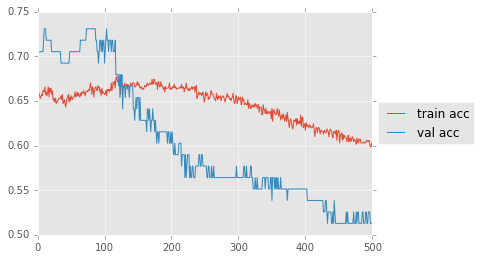

In [128]:
my_lstm.visualize_acc(result=result, epoch=epoch)

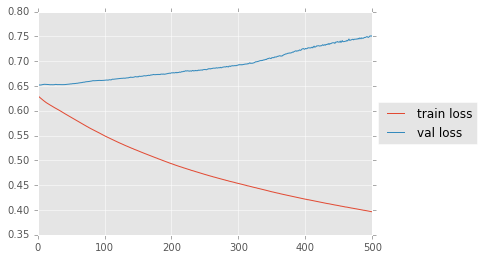

In [129]:
my_lstm.visualize_loss(result=result, epoch=epoch)

## kNN

In [90]:
from sklearn import neighbors

### data load for kNN

In [277]:
output_dim = 6
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=output_dim)

In [278]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1, weights='uniform')
clf.fit(train['x'], train['y'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [279]:
preds = clf.predict(test['x'])

acc_ls = []
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    acc_ls.append(sum_ / all_)

for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i + 1, acc_)

accuracy for 1 th dim: 0.658385
accuracy for 2 th dim: 0.531056
accuracy for 3 th dim: 0.524845
accuracy for 4 th dim: 0.503106
accuracy for 5 th dim: 0.552795
accuracy for 6 th dim: 0.540373


In [280]:
acc_all, acc_sum, res = 0.0, 0.0, []
for pred, y_test_ in zip(preds, test['y']):
    res = pred == y_test_
    acc_sum += 1.0
    if res.all():
        acc_all += 1.0
acc_all = acc_all / acc_sum

In [281]:
acc_all

0.06832298136645963

## seq2seq

In [14]:
import seq2seq
from seq2seq.models import SimpleSeq2seq

### data load for SimpleSeq2Seq

In [357]:
output_dim = 1
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=output_dim)
base_estimator.param_new(rows=1, cols=30, output_dim=6)
x_train, y_train, x_test, y_test = base_estimator.data_transform(train, test)
y_train = y_train.reshape(y_train.shape[0], 1, output_dim)

### model

In [358]:
model = SimpleSeq2seq(input_dim=30, hidden_dim=10, output_length=1, output_dim=output_dim)
model.compile(loss='mse', optimizer='rmsprop')

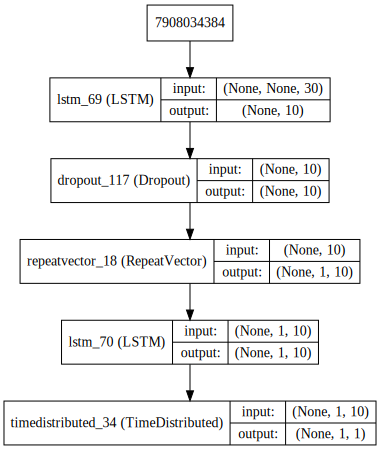

In [359]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [360]:
batch_size = 50
epoch = 50
validation_split = 0.1
result = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=epoch, validation_split=validation_split)

Train on 3239 samples, validate on 360 samples
Epoch 1/50
3239/3239 [==============================] - 0s - loss: 0.2868 - val_loss: 0.2135
Epoch 2/50
3239/3239 [==============================] - 0s - loss: 0.2205 - val_loss: 0.1971
Epoch 3/50
3239/3239 [==============================] - 0s - loss: 0.2131 - val_loss: 0.1959
Epoch 4/50
3239/3239 [==============================] - 0s - loss: 0.2091 - val_loss: 0.1945
Epoch 5/50
3239/3239 [==============================] - 0s - loss: 0.2077 - val_loss: 0.1953
Epoch 6/50
3239/3239 [==============================] - 0s - loss: 0.2091 - val_loss: 0.1956
Epoch 7/50
3239/3239 [==============================] - 0s - loss: 0.2027 - val_loss: 0.1948
Epoch 8/50
3239/3239 [==============================] - 0s - loss: 0.2002 - val_loss: 0.1949
Epoch 9/50
3239/3239 [==============================] - 0s - loss: 0.2006 - val_loss: 0.1964
Epoch 10/50
3239/3239 [==============================] - 0s - loss: 0.1986 - val_loss: 0.1960
Epoch 11/50
3239/3239 

In [361]:
preds = model.predict(x_test)
preds = preds.reshape(preds.shape[0], output_dim)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
acc_ls = []
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = y_test[:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    acc_ls.append(sum_ / all_)

for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.726738


In [356]:
acc_all, acc_sum, res = 0.0, 0.0, []
for pred, y_test_ in zip(preds, y_test):
    res = pred == y_test_
    acc_sum += 1
    if res.all():
        acc_all += 1.0
acc_all = acc_all / acc_sum
acc_all

0.567530695770805

## seq2seq (stacked)

### data load for seq2seq (stacked)

In [368]:
output_dim = 3
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=output_dim)
base_estimator.param_new(rows=1, cols=30, output_dim=6)
x_train, y_train, x_test, y_test = base_estimator.data_transform(train, test)
y_train = y_train.reshape(y_train.shape[0], 1, output_dim)

### model

In [369]:
model = SimpleSeq2seq(input_dim=30, hidden_dim=10, output_length=1, output_dim=output_dim, depth=3)
model.compile(loss='mse', optimizer='rmsprop')

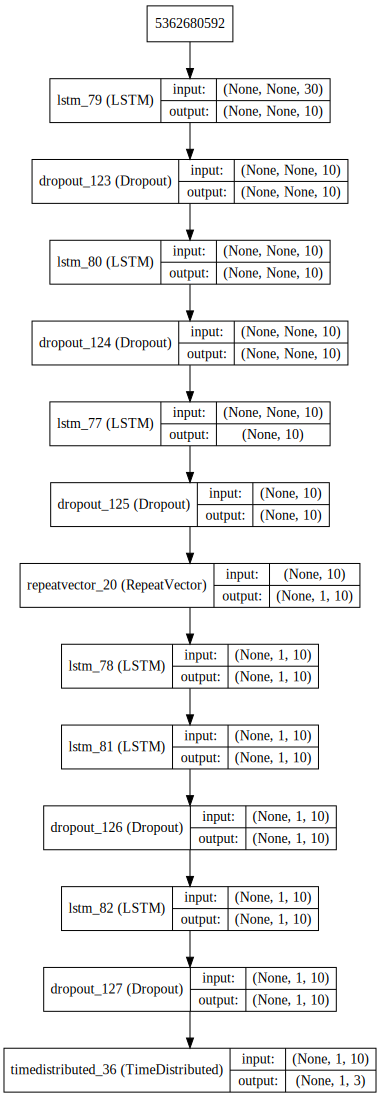

In [370]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [371]:
batch_size = 50
epoch = 300
validation_split = 0.1
result = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=epoch, validation_split=validation_split)

Train on 1485 samples, validate on 165 samples
Epoch 1/300
1485/1485 [==============================] - 0s - loss: 0.5289 - val_loss: 0.5037
Epoch 2/300
1485/1485 [==============================] - 0s - loss: 0.4299 - val_loss: 0.3860
Epoch 3/300
1485/1485 [==============================] - 0s - loss: 0.3288 - val_loss: 0.2718
Epoch 4/300
1485/1485 [==============================] - 0s - loss: 0.2661 - val_loss: 0.2309
Epoch 5/300
1485/1485 [==============================] - 0s - loss: 0.2491 - val_loss: 0.2202
Epoch 6/300
1485/1485 [==============================] - 0s - loss: 0.2455 - val_loss: 0.2132
Epoch 7/300
1485/1485 [==============================] - 0s - loss: 0.2469 - val_loss: 0.2150
Epoch 8/300
1485/1485 [==============================] - 0s - loss: 0.2428 - val_loss: 0.2110
Epoch 9/300
1485/1485 [==============================] - 0s - loss: 0.2381 - val_loss: 0.2107
Epoch 10/300
1485/1485 [==============================] - 0s - loss: 0.2366 - val_loss: 0.2101
Epoch 11/300

In [372]:
preds = model.predict(x_test)
preds = preds.reshape(preds.shape[0], output_dim)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
acc_ls = []
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = y_test[:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    acc_ls.append(sum_ / all_)

for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.704167
accuracy for 1 th dim: 0.683333
accuracy for 2 th dim: 0.608333


In [373]:
acc_all, acc_sum, res = 0.0, 0.0, []
for pred, y_test_ in zip(preds, y_test):
    res = pred == y_test_
    acc_sum += 1
    if res.all():
        acc_all += 1.0
acc_all = acc_all / acc_sum
acc_all

0.425

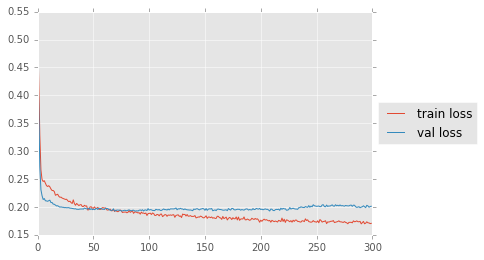

In [375]:
x = range(epoch)
plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Attention Seq2Seq

In [492]:
from seq2seq.models import AttentionSeq2seq

### data load for attention seq2seq

In [493]:
output_dim = 6
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=output_dim)
base_estimator.param_new(rows=1, cols=30, output_dim=6)
x_train, y_train, x_test, y_test = base_estimator.data_transform(train, test)
y_train = y_train.reshape(y_train.shape[0], 1, output_dim)

### model

In [495]:
model = AttentionSeq2seq(input_dim=30, input_length=30, hidden_dim=30, output_length=1, output_dim=6, depth=4)
model.compile(loss='mse', optimizer='rmsprop')

Exception: AttentionDecoder requires input_length.

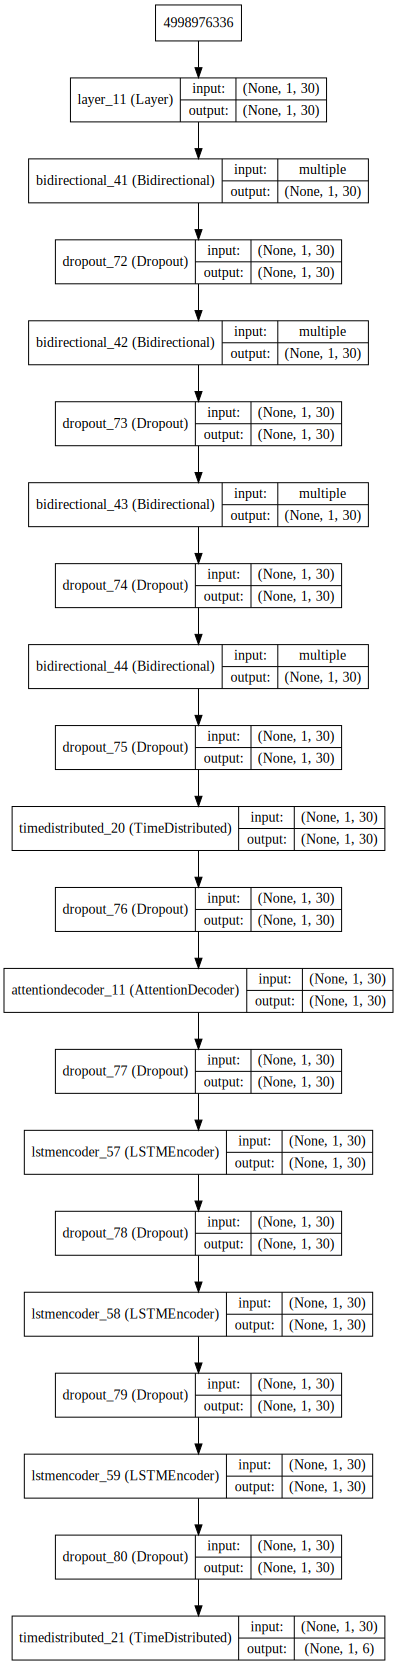

In [67]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [68]:
batch_size = 50
epoch = 50
validation_split = 0.1
result = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=epoch, validation_split=validation_split)

Train on 700 samples, validate on 78 samples
Epoch 1/50
700/700 [==============================] - 0s - loss: 0.5579 - val_loss: 0.4624
Epoch 2/50
700/700 [==============================] - 0s - loss: 0.3294 - val_loss: 0.2307
Epoch 3/50
700/700 [==============================] - 0s - loss: 0.2392 - val_loss: 0.2208
Epoch 4/50
700/700 [==============================] - 0s - loss: 0.2308 - val_loss: 0.2166
Epoch 5/50
700/700 [==============================] - 0s - loss: 0.2251 - val_loss: 0.2151
Epoch 6/50
700/700 [==============================] - 0s - loss: 0.2200 - val_loss: 0.2124
Epoch 7/50
700/700 [==============================] - 0s - loss: 0.2195 - val_loss: 0.2153
Epoch 8/50
700/700 [==============================] - 0s - loss: 0.2172 - val_loss: 0.2138
Epoch 9/50
700/700 [==============================] - 0s - loss: 0.2144 - val_loss: 0.2161
Epoch 10/50
700/700 [==============================] - 0s - loss: 0.2133 - val_loss: 0.2148
Epoch 11/50
700/700 [=======================

In [69]:
preds = model.predict(x_test).reshape(preds.shape[0], output_dim)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
acc_ls = []
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = y_test[:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    acc_ls.append(sum_ / all_)

for i, acc_ in enumerate(acc_ls):
    print 'accuracy for %s th dim: %f' % (i, acc_)

accuracy for 0 th dim: 0.708075
accuracy for 1 th dim: 0.627329
accuracy for 2 th dim: 0.621118
accuracy for 3 th dim: 0.583851
accuracy for 4 th dim: 0.593168
accuracy for 5 th dim: 0.552795


## seq2seq(peeky)

In [498]:
from seq2seq.models import Seq2seq

### data load for seq2seq(peeky)

In [511]:
output_dim = 6
train, test, target = base_data_manager.load_normal_representation_data(data_type='balance', category_name='ajax', output_dim=output_dim)
base_estimator.param_new(rows=1, cols=30, output_dim=6)
x_train, y_train, x_test, y_test = base_estimator.data_transform(train, test)
y_train = y_train.reshape(y_train.shape[0], 1, output_dim)

In [513]:
model = Seq2seq(batch_input_shape=(50, 1, 30), hidden_dim=10, output_length=1, output_dim=output_dim, depth=4, peek=True)
model.compile(loss='mse', optimizer='rmsprop')

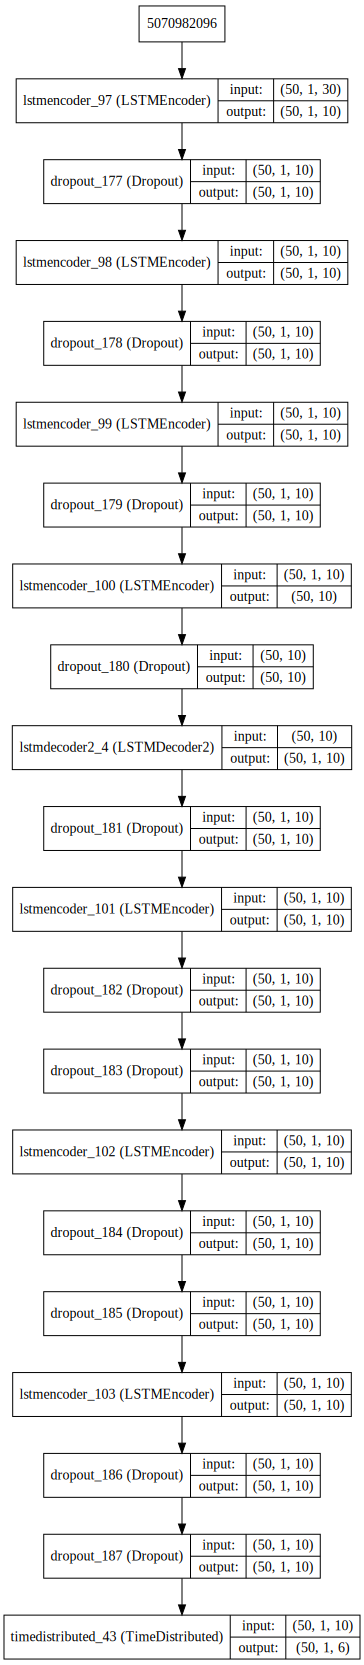

In [514]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [510]:
batch_size = 50
epoch = 50
validation_split = 0.1
result = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=epoch, validation_split=validation_split)

Train on 700 samples, validate on 78 samples
Epoch 1/50
650/700 [==========================>...] - ETA: 0s - loss: 0.5784

ValueError: Shape mismatch: x has 50 rows but z has 28 rows
Apply node that caused the error: Gemm{no_inplace}(Subtensor{::, int64::}.0, TensorConstant{0.20000000298}, <TensorType(float32, matrix)>, lstmencoder_89_U_o_copy, TensorConstant{0.20000000298})
Toposort index: 5
Inputs types: [TensorType(float32, matrix), TensorType(float32, scalar), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(28, 10), (), (50, 10), (10, 10), ()]
Inputs strides: [(160, 4), (), (40, 4), (40, 4), ()]
Inputs values: ['not shown', array(0.20000000298023224, dtype=float32), 'not shown', 'not shown', array(0.20000000298023224, dtype=float32)]
Outputs clients: [[Elemwise{Composite{(clip((i0 + i1), i2, i3) * tanh(i4))}}(TensorConstant{(1, 1) of 0.5}, Gemm{no_inplace}.0, TensorConstant{(1, 1) of 0}, TensorConstant{(1, 1) of 1}, Elemwise{Composite{((clip((i0 + i1), i2, i3) * i4) + (clip((i5 + i6), i2, i3) * tanh(i7)))}}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: forall_inplace,cpu,scan_fn}(TensorConstant{1}, InplaceDimShuffle{1,0,2}.0, IncSubtensor{InplaceSet;:int64:}.0, IncSubtensor{InplaceSet;:int64:}.0, TensorConstant{1}, lstmencoder_89_U_o, lstmencoder_89_U_f, lstmencoder_89_U_i, lstmencoder_89_U_c)
Toposort index: 196
Inputs types: [TensorType(int64, scalar), TensorType(float32, (True, False, False)), TensorType(float32, (True, False, False)), TensorType(float32, (True, False, False)), TensorType(int64, scalar), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(), (1, 28, 40), (1, 50, 10), (1, 50, 10), (), (10, 10), (10, 10), (10, 10), (10, 10)]
Inputs strides: [(), (4480, 160, 4), (2000, 40, 4), (2000, 40, 4), (), (40, 4), (40, 4), (40, 4), (40, 4)]
Inputs values: [array(1), 'not shown', 'not shown', 'not shown', array(1), 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[], [], [InplaceDimShuffle{1,0,2}(forall_inplace,cpu,scan_fn}.2)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Attention Time

### CNN pre-train

In [ ]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(6))

In [ ]:
max_caption_len = 16
vocab_size = 10000

# first, let's define an image model that
# will encode pictures into 128-dimensional vectors.
# it should be initialized with pre-trained weights.
image_model = Sequential()
image_model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(3, 100, 100)))
image_model.add(Activation('relu'))
image_model.add(Convolution2D(32, 3, 3))
image_model.add(Activation('relu'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))

image_model.add(Convolution2D(64, 3, 3, border_mode='valid'))
image_model.add(Activation('relu'))
image_model.add(Convolution2D(64, 3, 3))
image_model.add(Activation('relu'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))

image_model.add(Flatten())
image_model.add(Dense(100))

# let's load the weights from a save file.
image_model.load_weights('weight_file.h5')

# next, let's define a RNN model that encodes sequences of words
# into sequences of 128-dimensional word vectors.
timeseries_model = Sequential()
language_model.add((output_dim=100, return_sequences=True))
language_model.add(TimeDistributedDense(128))

# let's repeat the image vector to turn it into a sequence.
image_model.add(RepeatVector(max_caption_len))

# the output of both models will be tensors of shape (samples, max_caption_len, 128).
# let's concatenate these 2 vector sequences.
model = Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
# let's encode this vector sequence into a single vector
model.add(GRU(256, return_sequences=False))
# which will be used to compute a probability
# distribution over what the next word in the caption should be!
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# "images" is a numpy float array of shape (nb_samples, nb_channels=3, width, height).
# "captions" is a numpy integer array of shape (nb_samples, max_caption_len)
# containing word index sequences representing partial captions.
# "next_words" is a numpy float array of shape (nb_samples, vocab_size)
# containing a categorical encoding (0s and 1s) of the next word in the corresponding
# partial caption.
model.fit([images, partial_captions], next_words, batch_size=16, nb_epoch=100)

In [ ]:
max_caption_len = 21
vocab_size = 43
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    #Remove the last two layers to get the 4096D activations
    model.layers.pop()
    model.layers.pop()

    return model
print "VGG loading"
image_model = VGG_16('vgg16_weights.h5')
image_model.trainable = False
print "VGG loaded"
# let's load the weights from a save file.
# image_model.load_weights('weight_file.h5')

# next, let's define a RNN model that encodes sequences of words
# into sequences of 128-dimensional word vectors.
print "Text model loading"
language_model = Sequential()
language_model.add(Embedding(vocab_size, 256, input_length=max_caption_len))
language_model.add(GRU(output_dim=128, return_sequences=True))
language_model.add(TimeDistributedDense(128))
print "Text model loaded"
# let's repeat the image vector to turn it into a sequence.
print "Repeat model loading"
image_model.add(RepeatVector(max_caption_len))
print "Repeat model loaded"
# the output of both models will be tensors of shape (samples, max_caption_len, 128).
# let's concatenate these 2 vector sequences.
print "Merging"
model = Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
# let's encode this vector sequence into a single vector
model.add(GRU(256, return_sequences=False))
# which will be used to compute a probability
# distribution over what the next word in the caption should be!
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print "Merged"
# "images" is a numpy float array of shape (nb_samples, nb_channels=3, width, height).
# "captions" is a numpy integer array of shape (nb_samples, max_caption_len)
# containing word index sequences representing partial captions.
# "next_words" is a numpy float array of shape (nb_samples, vocab_size)
# containing a categorical encoding (0s and 1s) of the next word in the corresponding
# partial caption.
print "Data preprocessig"
Texts = ["START A girl is stretched out in shallow water END",
        "START The two people stand by a body of water and in front of bushes in fall END",
        "START A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel END",
        "START Children sit and watch the fish moving in the pond END",
        "START A fisherman fishes at the bank of a foggy river END"]

Images = ["667626_18933d713e.jpg",
         "3637013_c675de7705.jpg",
         "10815824_2997e03d76.jpg",
         "12830823_87d2654e31.jpg",
         "17273391_55cfc7d3d4.jpg"]
images = []
for image in Images:
    img = cv2.imread(image)
    img.resize((3,224,224))
    images.append(img)
images = np.asarray(images)

words = [txt.split() for txt in Texts]
unique = []
for word in words:
    unique.extend(word)
unique = list(set(unique))
word_index = {}
index_word = {}
for i,word in enumerate(unique):
    word_index[word] = i
    index_word[i] = word

partial_captions = []
for text in Texts:
    one = [word_index[txt] for txt in text.split()]
    partial_captions.append(one)

partial_captions = sequence.pad_sequences(partial_captions, maxlen=max_caption_len,padding='post')
next_words = np.zeros((5,vocab_size))
for i,text in enumerate(Texts):
    text = text.split()
    x = [word_index[txt] for txt in text]
    x = np.asarray(x)
    next_words[i,x] = 1

print "Data preprocessing done"
model.fit([images, partial_captions], next_words, batch_size=1, nb_epoch=5)